# Doublet Detection on 10k PBMCs from 10x Genomics v3

In [1]:
import numpy as np
import doubletdetection
import scanpy as sc
import matplotlib.pyplot as plt

sc.settings.n_jobs=8
sc.set_figure_params()

## Download Data from 10x

### Load Count Matrix

In [2]:
adata = sc.read_10x_h5(
    "pbmc_10k_v3_filtered_feature_bc_matrix.h5", 
    backup_url="https://cf.10xgenomics.com/samples/cell-exp/3.0.0/pbmc_10k_v3/pbmc_10k_v3_filtered_feature_bc_matrix.h5"
)
adata.var_names_make_unique()

Variable names are not unique. To make them unique, call `.var_names_make_unique`.
Variable names are not unique. To make them unique, call `.var_names_make_unique`.


In [3]:
# remove "empty" genes
sc.pp.filter_genes(adata, min_cells=1)


## Run Doublet Detection

Here we show-off the new backend implementation that uses `scanpy`. This new implementation is over 2x faster than version 2.4.0. To use the previous version of DoubletDetection please add the parameters (`use_phenograph=True`, `verbose=True`, `standard_scaling=False`) to the classifier and use the thresholds `p_thresh=1e-7`, `voter_thresh=0.8`. We recommend first using these parameters until we further validate the new implementation.

In [4]:
clf = doubletdetection.BoostClassifier(
    n_iters=25, 
    use_phenograph=False, 
    standard_scaling=True
)
doublets = clf.fit(adata.X).predict(p_thresh=1e-16, voter_thresh=0.5)
doublet_score = clf.doublet_score()

100%|██████████| 25/25 [04:49<00:00, 11.58s/it]


In [5]:
adata.obs["doublet"] = doublets
adata.obs["doublet_score"] = doublet_score

## Visualize Results

### Convergence of doublet calls

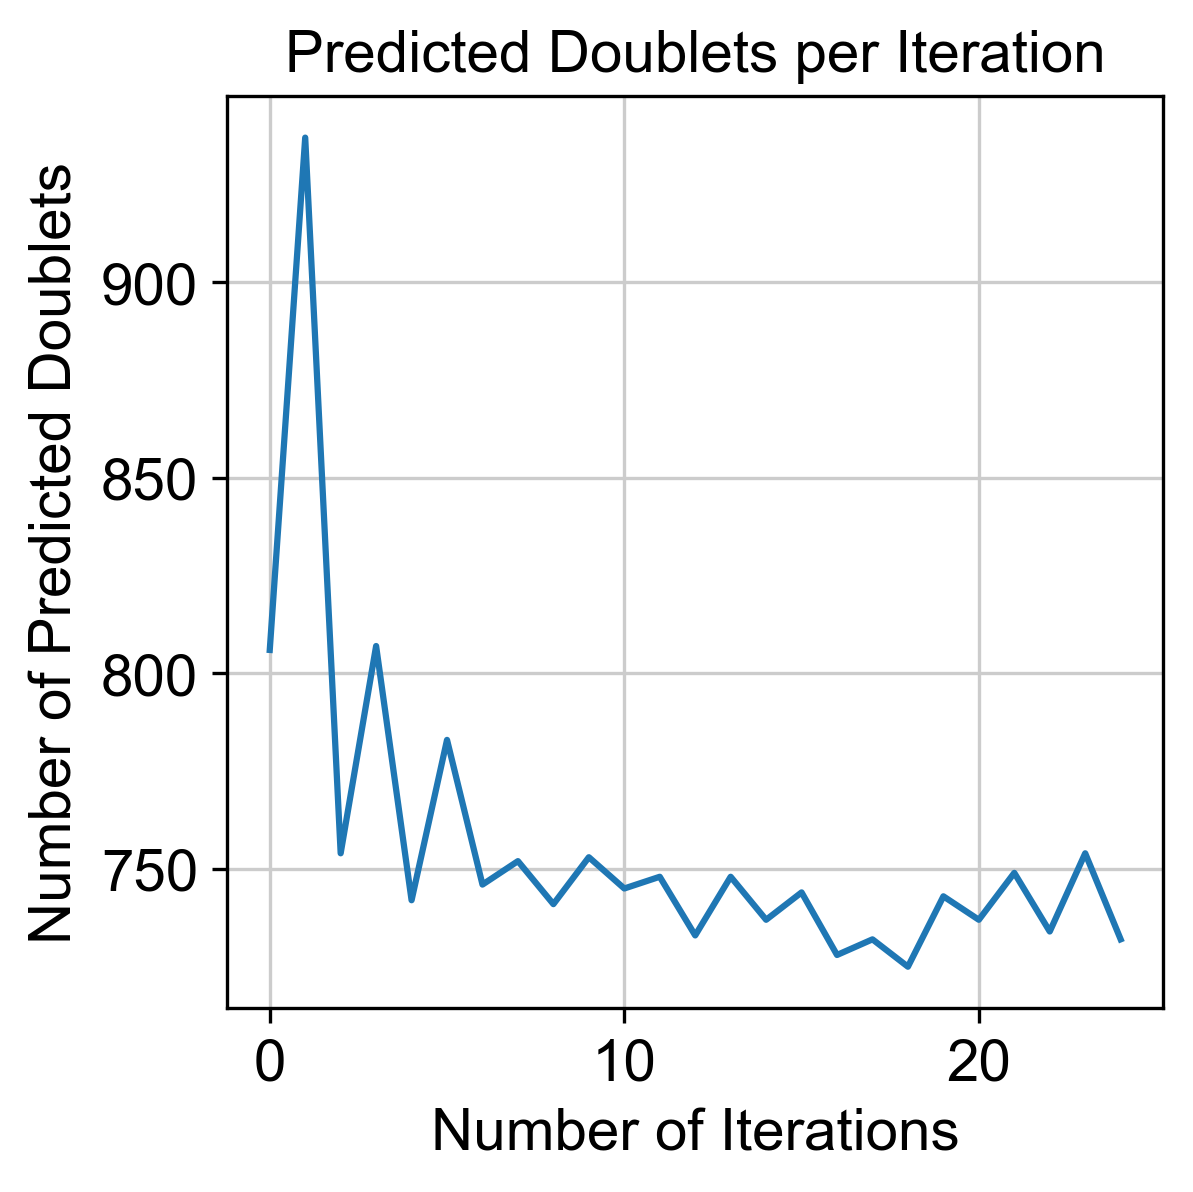

In [6]:
f = doubletdetection.plot.convergence(clf, save='convergence_test.pdf', show=True, p_thresh=1e-16, voter_thresh=0.5)

### Doublets on umap

In [7]:
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata)
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

... storing 'feature_types' as categorical
... storing 'genome' as categorical


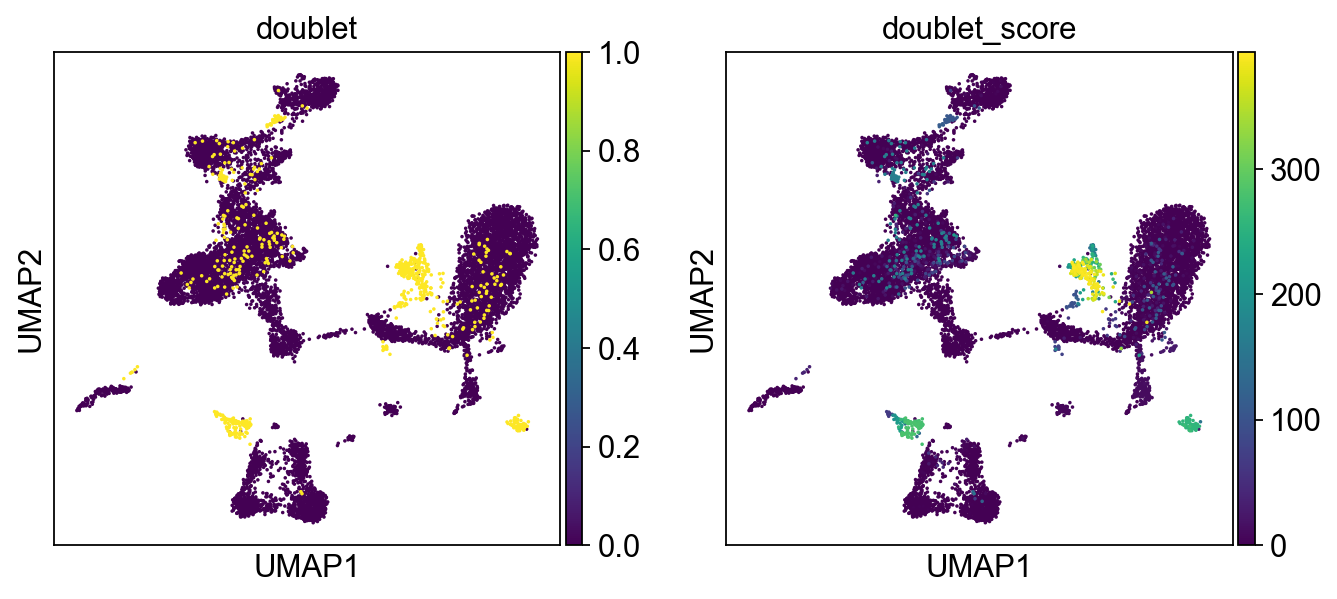

In [8]:
sc.pl.umap(adata, color=["doublet", "doublet_score"])

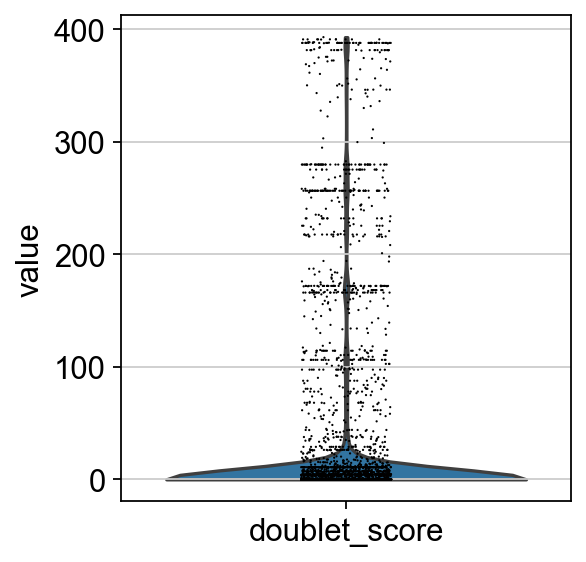

In [9]:
sc.pl.violin(adata, "doublet_score")

### Number of predicted doublets at different threshold combinations

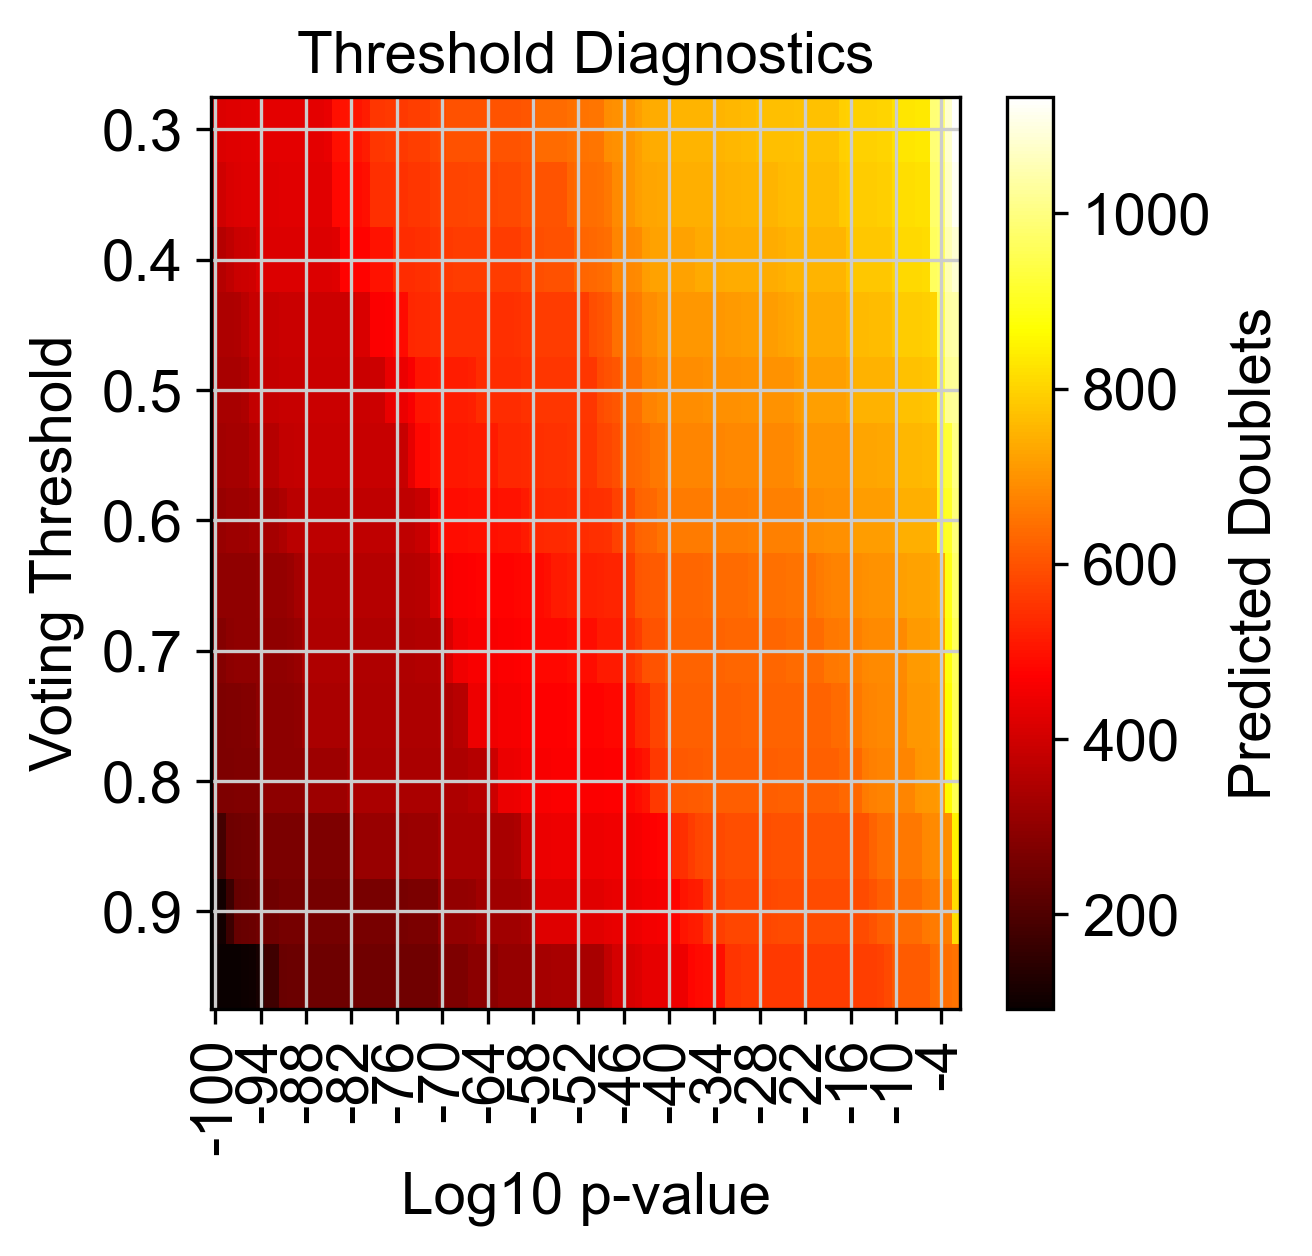

In [10]:
f3 = doubletdetection.plot.threshold(clf, save='threshold_test.pdf', show=True, p_step=6)